In [1]:
import os
import sys
MODULE_FULL_PATH = '/home/spopov/focus/pfe'
sys.path.insert(1, MODULE_FULL_PATH)
sys.path.append('.')

import os
import sys
import time
import math
import argparse
import numpy as np

from network import Network
from utils import utils
from utils.dataset import Dataset
from utils.imageprocessing import preprocess


from retinaface import RetinaFace
from sklearn.cluster import DBSCAN

import align.crop_ijba as crop
import align.align_dataset as align



In [2]:
PFE_PATH='/home/spopov/focus/pfe'
DATASET_PATH = os.path.join(PFE_PATH, 'data/IJB-B/')
HINTS_FILEPATH = os.path.join(DATASET_PATH, 'protocol/cluster/test8/ijbb_detection_clustering_hint_100000.csv')
IMAGES_PATH = os.path.join(DATASET_PATH, 'images/')

IMAGE_SIZE = [96, 112]

class Template:
    def __init__(self, template_id, label):
        self.template_id = template_id
        self.label = label
        self.features = None
        self.img = None

In [3]:
import pandas as pd

hints_filenames = pd.read_csv(HINTS_FILEPATH)
print(hints_filenames.iloc[1][0])

frames/10003.png


In [4]:
gpuid = 0
detector = RetinaFace(os.path.join(PFE_PATH, 'model/R50'), 0, gpuid, 'net3')

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
means [0. 0. 0.]
use_landmarks True
cascade 0
sym size: 9


In [5]:
network = Network()
network.load_model('/home/spopov/focus/pfe/log/sphere64_casia_am_PFE/20200515-123838')
proc_func = lambda x: preprocess(x, network.config, False)

Metagraph file: /home/spopov/focus/pfe/log/sphere64_casia_am_PFE/20200515-123838/graph.meta
Checkpoint file: /home/spopov/focus/pfe/log/sphere64_casia_am_PFE/20200515-123838/ckpt-3000
INFO:tensorflow:Restoring parameters from /home/spopov/focus/pfe/log/sphere64_casia_am_PFE/20200515-123838/ckpt-3000


INFO:tensorflow:Restoring parameters from /home/spopov/focus/pfe/log/sphere64_casia_am_PFE/20200515-123838/ckpt-3000


[ 938    0 1050  112    0]
(938, 0, 112, 112)
uint8
(112, 112, 3)
float64
face_landmarks: 
 [[ 964.3525     37.186306]
 [1014.28973    30.89666 ]
 [ 989.98566    60.88378 ]
 [ 976.5404     82.81228 ]
 [1017.5793     76.93334 ]]
938 0
src_pts: 
 [[26.35247802734375, 37.18630599975586], [76.28973388671875, 30.89665985107422], [51.98565673828125, 60.88378143310547], [38.5404052734375, 82.8122787475586], [79.57928466796875, 76.93334197998047]]
[161 442 286 605   0]
(161, 442, 125, 163)
uint8
(163, 163, 3)
float64
face_landmarks: 
 [[190.69096 514.5557 ]
 [245.61002 513.4543 ]
 [215.42421 547.5922 ]
 [197.62183 568.4501 ]
 [242.83249 567.051  ]]
161 442
src_pts: 
 [[29.690963745117188, 72.55572509765625], [84.61001586914062, 71.45428466796875], [54.42420959472656, 105.59222412109375], [36.621826171875, 126.4500732421875], [81.83248901367188, 125.051025390625]]
[636 121 772 282   0]
(636, 121, 136, 161)
uint8
(161, 161, 3)
float64
face_landmarks: 
 [[659.3479  177.41617]
 [713.6343  182.3749

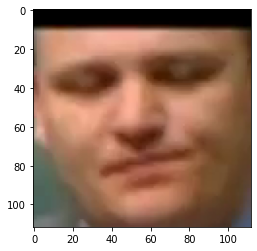

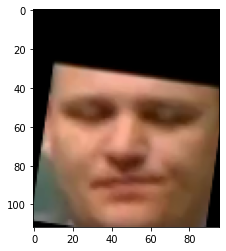

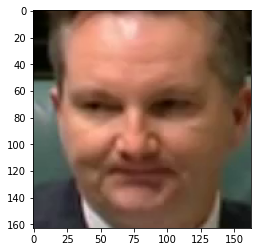

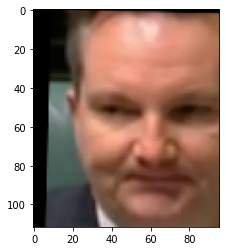

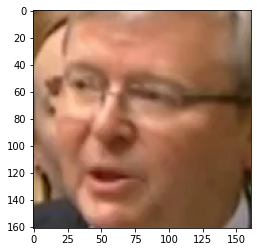

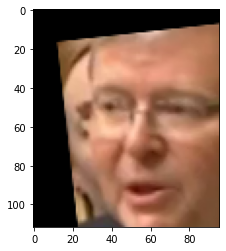

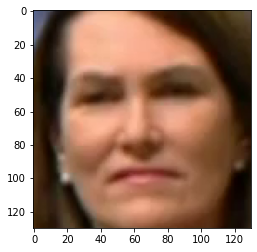

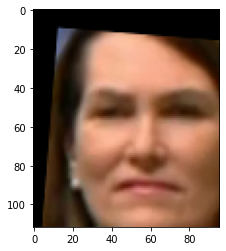

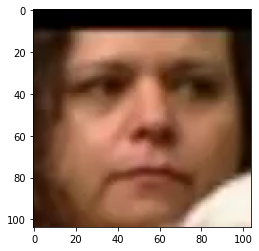

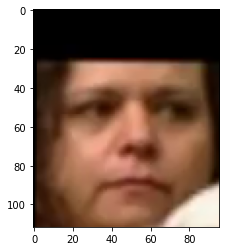

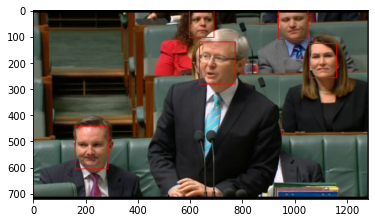

[1053  134 1159  264    0]
(1053, 134, 106, 130)
uint8
(130, 130, 3)
float64
face_landmarks: 
 [[1076.4873   191.2901 ]
 [1123.6393   184.68925]
 [1100.9822   214.58562]
 [1089.561    237.14442]
 [1127.5991   231.27522]]
1053 134
src_pts: 
 [[23.4873046875, 57.29010009765625], [70.6392822265625, 50.68925476074219], [47.982177734375, 80.58561706542969], [36.56103515625, 103.14442443847656], [74.59912109375, 97.27522277832031]]
[ 911    0 1013  118    0]
(911, 0, 102, 118)
uint8
(118, 118, 3)
float64
face_landmarks: 
 [[921.3613    41.789276]
 [950.75616   40.47772 ]
 [920.98157   67.50735 ]
 [934.23975   87.38521 ]
 [957.38007   85.246666]]
911 0
src_pts: 
 [[10.361328125, 41.789276123046875], [39.75616455078125, 40.477718353271484], [9.9815673828125, 67.5073471069336], [23.23974609375, 87.38520812988281], [46.38006591796875, 85.24666595458984]]
[184 478 309 627   0]
(184, 478, 125, 149)
uint8
(149, 149, 3)
float64
face_landmarks: 
 [[232.77762 548.722  ]
 [284.82928 548.49963]
 [263.32

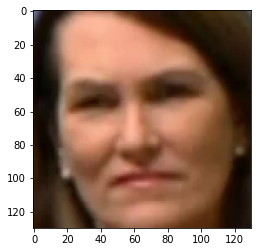

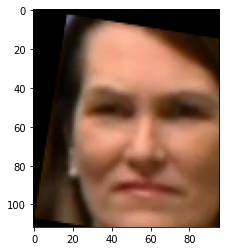

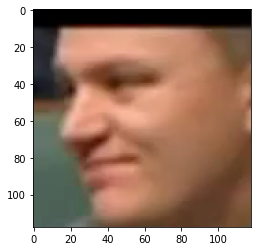

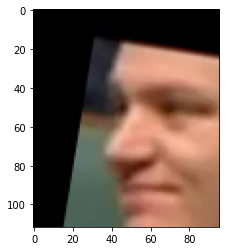

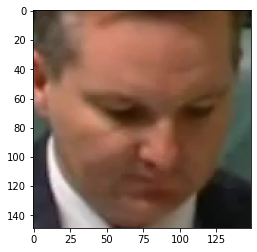

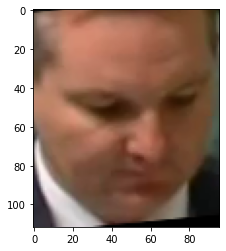

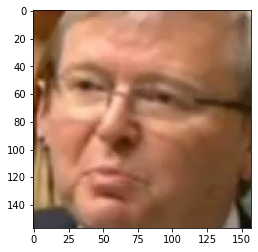

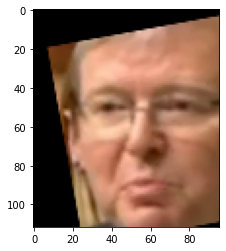

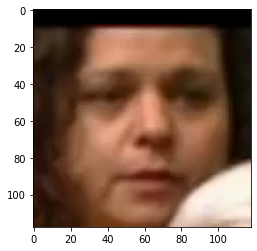

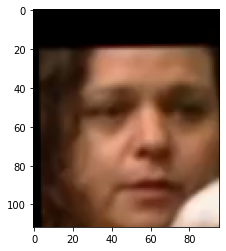

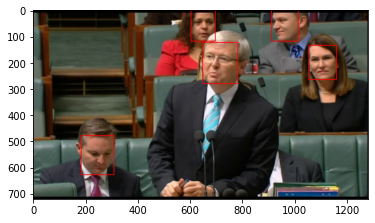

[630 124 759 290   0]
(630, 124, 129, 166)
uint8
(166, 166, 3)
float64
face_landmarks: 
 [[647.6597  182.73659]
 [697.35547 188.71484]
 [653.4939  214.06827]
 [644.4042  246.22302]
 [681.3904  251.7085 ]]
630 124
src_pts: 
 [[17.65972900390625, 58.73658752441406], [67.35546875, 64.71484375], [23.493896484375, 90.06826782226562], [14.4041748046875, 122.2230224609375], [51.390380859375, 127.70849609375]]
[1053  135 1159  264    0]
(1053, 135, 106, 129)
uint8
(129, 129, 3)
float64
face_landmarks: 
 [[1076.9185   191.52858]
 [1123.8376   185.02808]
 [1101.337    214.28587]
 [1089.7139   236.71312]
 [1127.8097   230.92397]]
1053 135
src_pts: 
 [[23.91845703125, 56.52857971191406], [70.837646484375, 50.028076171875], [48.3370361328125, 79.28587341308594], [36.7138671875, 101.71311950683594], [74.8096923828125, 95.92396545410156]]
[184 476 308 626   0]
(184, 476, 124, 150)
uint8
(150, 150, 3)
float64
face_landmarks: 
 [[231.70784 549.0497 ]
 [283.93256 548.2338 ]
 [262.76993 584.43677]
 [233.

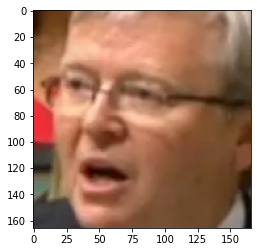

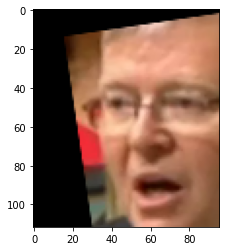

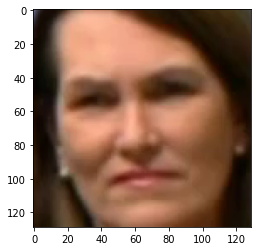

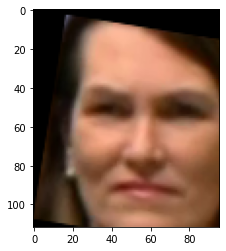

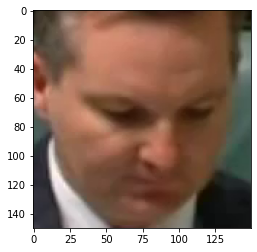

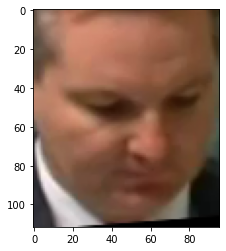

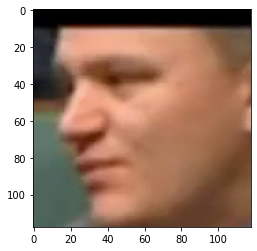

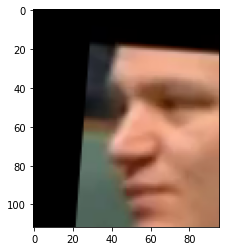

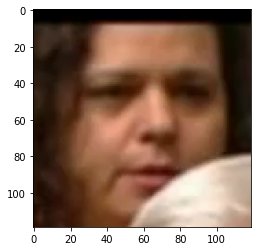

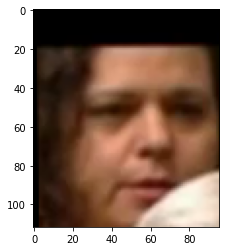

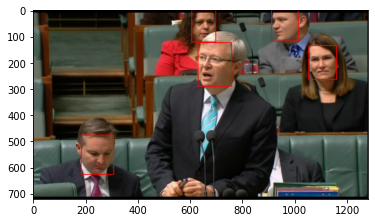

In [16]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt

templates = []
template_id = 0

count_fail = 0
count_success = 0

for i, filename in enumerate(hints_filenames['FILENAME'][:3], 1):
    image_path = os.path.join(IMAGES_PATH, filename)
    img = cv2.imread(image_path, flags=1)
    
    if img is None or img.ndim == 0:
        print('Invalid image: %s' % impath)
        count_fail += 1
        continue
        
    faces, landmarks = detector.detect(img)
    
    if faces is None:
        continue
        
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(faces.shape[0]):
        box = faces[i].astype(np.int)
        
        cv2.rectangle(rgb, (box[0], box[1]), (box[2], box[3]), (255,0,0), 2)
        print(box)
        
        bbox = (box[0], box[1], box[2] - box[0], box[3] - box[1])
        print(bbox)
        if crop.square_crop:
            bbox = crop.square_bbox(bbox)
        bbox = crop.pad_bbox(bbox, crop.padding_ratio)
        print(img.dtype)
        
        crop_img = crop.crop(img, bbox)
        print(crop_img.shape)
        print(crop_img.dtype)
        
        imgg = crop_img / np.max(crop_img) # normalize the data to 0 - 1
        imgg = 255 * imgg # Now scale by 255
        imgg = imgg.astype(np.uint8)
        crop_rgb = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)

        plt.figure()
        plt.imshow(crop_rgb)
        
        face_landmarks = landmarks[i]
        print('face_landmarks: \n', face_landmarks)
        print(box[0] ,box[1])
        src_pts = [[face_landmarks[j][0] - box[0], face_landmarks[j][1] - box[1]] for j in range(5)]
        print('src_pts: \n', src_pts)
        align_img, _, _ = align.align(crop_img, src_pts, align.ref_pts, IMAGE_SIZE)

        imgg = align_img / np.max(align_img) # normalize the data to 0 - 1
        imgg = 255 * imgg # Now scale by 255
        imgg = imgg.astype(np.uint8)
        align_rgb = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)

        plt.figure()
        plt.imshow(align_rgb)
        
        templates.append(Template(template_id, filename))
        template_id += 1
    
    plt.figure()
    plt.imshow(rgb)
    plt.show()

    count_success += 1
    

